# Task Description

The notebook includes the BERT model for category detection task. Due its straightforward structure and better results (in comparison to Pytorch), I picked the Tensorflow package for BERT model for this task. After I conduct necessary data cleaning and processing, I subtract three necessary inputs of a BERT model. I applied the model through downloading the base pretrained BERT layer from Tensorflow hub and add to the neural network model as a Keras layer.

I followed the model developing through the graphs of validation loss and precision and recall, which seem proper for a well functioning neural network model. For the success of the model I paid my attention on F1 score (among other metrics) the most.

To elaborate the result, I checked the labelwise classification report which shows the precision, recall and the f1 score for each label and the confusion metrices that I constructed manually for each label. 

# Packages

In [ ]:
pip install transformers

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns
import string 
import tensorflow as tf
import tensorflow_hub as hub

from sklearn.metrics import accuracy_score, average_precision_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score, hamming_loss, roc_auc_score, roc_curve
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall, FalseNegatives, FalsePositives
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from transformers import BertTokenizer

# Data Preprocessing 

In [ ]:
# Import data
train = pd.read_excel('Trainset.xlsx')
test = pd.read_excel('Testset.xlsx')

# Eliminate the NAs
train = train.fillna('')
test = test.fillna('')

# Remove the rows without Opinion Category values
train = train[train.OpinionCategory != ''] 
test = test[test.OpinionCategory != ''] 

# Sort the data
train = train.sort_values('Sentence_ID').reset_index(drop=True)
test = test.sort_values('Sentence_ID').reset_index(drop=True)
train.head()

,ID_number,Review_ID,ID_and_Review,OutOfScope,Sentence_ID,OpinionCategory,OpinionFrom,Polarity,AspectTerm,OpinionTo,Text
0,1004293,1,1004293:0,,1,RESTAURANT#GENERAL,51,negative,place,56,Judging from previous posts this used to be a ...
1,1004293,1,1004293:1,,2,SERVICE#GENERAL,75,negative,staff,80,"We, there were four of us, arrived at noon - t..."
2,1004293,1,1004293:2,,3,SERVICE#GENERAL,0,negative,,0,"They never brought us complimentary noodles, i..."
3,1004293,1,1004293:3,,4,FOOD#QUALITY,4,negative,food,8,The food was lousy - too sweet or too salty an...
4,1004293,1,1004293:3,,4,FOOD#STYLE_OPTIONS,52,negative,portions,60,The food was lousy - too sweet or too salty an...


In [ ]:
train.shape, test.shape

((2507, 11), (859, 11))

Train data consists of 11 variables. The four of them indicate the ID numbers of the sentences, the reviewer, the review and the combination of them. OutofScope variable loses its function when I eliminated the null OpinionCategory values. The Opinion Category shows the aspect which the review refers to. The Opinion Category consists of 12 classes and each class has an entity and a corresponding attribute, in other words, E#A pairs. 


In this notebook, I will deal only with the Opinion Category and the corresponding reviews under the Text column and leave the analysis for Polarity and AspectTerm (and related columns with AspectTerm) to other notebooks. 

## Label Counts

In [ ]:
train.OpinionCategory.value_counts()

FOOD#QUALITY                849
SERVICE#GENERAL             449
RESTAURANT#GENERAL          422
AMBIENCE#GENERAL            255
FOOD#STYLE_OPTIONS          137
RESTAURANT#MISCELLANEOUS     98
FOOD#PRICES                  90
RESTAURANT#PRICES            80
DRINKS#QUALITY               47
DRINKS#STYLE_OPTIONS         32
LOCATION#GENERAL             28
DRINKS#PRICES                20
Name: OpinionCategory, dtype: int64

As it can be seen above, the aspects mentioned in the sentences fall into 12 different categories. The distribution of categories is quite imbalanced, as the four biggest categories correspond to 78% of the training data.

## Multilabeling

In [ ]:
# First, one-hot encode each sentence (duplicate ones as well)
train.OpinionCategory = train.OpinionCategory.astype('category')
one_hot = to_categorical(train.OpinionCategory.cat.codes)
one_hot = pd.DataFrame(one_hot)

test.OpinionCategory = test.OpinionCategory.astype('category')
one_hot_test = to_categorical(test.OpinionCategory.cat.codes)
one_hot_test = pd.DataFrame(one_hot_test)

one_hot.shape, one_hot_test.shape # There are 12 opinion category classes.

((2507, 12), (859, 12))

In [ ]:
# Subtract the necessary columns for the analysis
useful_train = train[['Sentence_ID','OpinionCategory','Text']]
useful_test = test[['Sentence_ID','OpinionCategory','Text']]

# Concatenate the train data and the one-hot-encoding of the opinion category classes.
data_train = pd.concat([useful_train, one_hot], axis=1)
data_test = pd.concat([useful_test, one_hot_test], axis=1)

# Since the reviewer may have mentioned more than one opinion in a sentence, 
# Sum up the one-hot-encoded classes of each sentence.
multi_label = data_train.groupby('Sentence_ID').sum().reset_index(drop=True)
multi_label_test = data_test.groupby('Sentence_ID').sum().reset_index(drop=True)

# In each sentence, an opinion category may be refered more than one.
# Because of that, there were values besides 0 and 1, after the summation.
# Since being refered is important rather than how many times, the values such as 2 or 3 are reverted to one.
multi_label = np.array(multi_label.astype(bool).astype(int))
multi_label_test = np.array(multi_label_test.astype(bool).astype(int))

# After the multi-labeling of the sentences, remove the duplicates.
train_Text = data_train.drop_duplicates(subset=['Sentence_ID'], keep='last').Text
test_Text = data_test.drop_duplicates(subset=['Sentence_ID'], keep='last').Text

multi_label, multi_label.shape, multi_label_test, multi_label_test.shape

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]]), (1708, 12), array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 1],
        [0, 0, 0, ..., 0, 0, 0]]), (587, 12))

### How many multilabels?

In [ ]:
row_sums = np.sum(multi_label, axis = 1)
unique_sums = list(set(row_sums))

counts = []
for i in unique_sums:
    counts.append(row_sums.tolist().count(i))
df_multi = pd.DataFrame({'multi_labels':unique_sums, 'counts_of_multi':counts})
df_multi

,multi_labels,counts_of_multi
0,1,1282
1,2,324
2,3,83
3,4,17
4,5,1
5,6,1


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, '# of categories')

<Figure size 432x288 with 0 Axes>

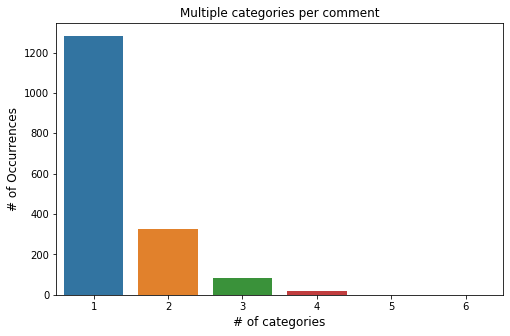

In [ ]:
#plot
plt.clf()
plt.figure(figsize=(8,5))
ax = sns.barplot(df_multi.multi_labels, df_multi.counts_of_multi)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

# Bert Tokenization

In [ ]:
# add special tokens for BERT to work properly
sentences = ["[CLS] " + sent + " [SEP]" for sent in train_Text.astype(str)]
sentences_test = ["[CLS] " + sent + " [SEP]" for sent in test_Text.astype(str)]

sentences[0], sentences_test[0]

('[CLS] Judging from previous posts this used to be a good place, but not any longer. [SEP]',
 '[CLS] Yum! [SEP]')

For the tokenization, pre-trained Bert-Base-Uncased dictionary is used. They constructed it with WordPiece embeddings with a 30,000 token vocabulary. 

In [ ]:
# Tokenize with BERT tokenizer both train and test data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
tokenized_texts_test = [tokenizer.tokenize(sent) for sent in sentences_test]

tokenized_texts[0], tokenized_texts_test[0]

(['[CLS]',
  'judging',
  'from',
  'previous',
  'posts',
  'this',
  'used',
  'to',
  'be',
  'a',
  'good',
  'place',
  ',',
  'but',
  'not',
  'any',
  'longer',
  '.',
  '[SEP]'],
 ['[CLS]', 'yu', '##m', '!', '[SEP]'])

# Input Preparation

For the BERT model to work, we need three inputs. 
- Input IDs: shows the ID number of each token with padding. The ID numbers are restored from the BERT vocabulary dictionary.
- Mask IDs: indicates which elements in the sequence are tokens and which are padding elements.
- Segment IDs: distinguishes different sentences, 0 for one-sentence sequence, 1 if there are two sentences. (For the model in this notebook, it will play no role, since the data is constructed with separate sentences for each observation.)


In [ ]:
def get_ids(tokens, tokenizer, max_seq_length):
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

def get_masks(tokens, max_seq_length):
    if len(tokens) > max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

def get_segments(tokens, max_seq_length):
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

In [ ]:
# find the longest sequence for the padding
def find_max_list(list):
    list_len = [len(i) for i in list]
    return max(list_len)
    
longestSeq_train = find_max_list(tokenized_texts)
longestSeq_test = find_max_list(tokenized_texts_test)
max_seq_length = max(longestSeq_train, longestSeq_test)
print(max_seq_length)

93


In [ ]:
# Find input_ids, mask_ids and segment_ids of the train and test data.
max_seq_length = max_seq_length
input_ids = []
mask_ids = [] 
segments_ids = []
for i in range(len(tokenized_texts)):
    input_ids.append(get_ids(tokenized_texts[i], tokenizer, max_seq_length))
    mask_ids.append(get_masks(tokenized_texts[i], max_seq_length))
    segments_ids.append(get_segments(tokenized_texts[i], max_seq_length))
    
input_ids_test = []
mask_ids_test = [] 
segments_ids_test = [] 
for i in range(len(tokenized_texts_test)):
    input_ids_test.append(get_ids(tokenized_texts_test[i], tokenizer, max_seq_length))
    mask_ids_test.append(get_masks(tokenized_texts_test[i], max_seq_length))
    segments_ids_test.append(get_segments(tokenized_texts_test[i], max_seq_length))
    
# For the model, I converted the lists to tensors.
input_ids = tf.convert_to_tensor(input_ids, dtype = tf.int32)
mask_ids = tf.convert_to_tensor(mask_ids, dtype = tf.int32)
segments_ids = tf.convert_to_tensor(segments_ids, dtype = tf.int32)

input_ids_test = tf.convert_to_tensor(input_ids_test, dtype = tf.int32)
mask_ids_test = tf.convert_to_tensor(mask_ids_test, dtype = tf.int32)
segments_ids_test = tf.convert_to_tensor(segments_ids_test, dtype = tf.int32)

# Model

The uncased BERT model is used with 12 hidden layers and 110M parameters, trained on Wikipedia and Book-Corpus data and hosted by Google on TensorFlow Hub. 

In [ ]:
random.seed(123)
# Three Inputs of the Bert Model
InputIDLayer = Input(shape = (max_seq_length,), dtype = tf.int32, name = "InputIDs")
MaskIDLayer = Input(shape = (max_seq_length,), dtype = tf.int32, name = "MaskIDs")
SegmentIDLayer = Input(shape = (max_seq_length,), dtype = tf.int32, name = "SegmentIDs")

# Import the pre-trained uncased Bert model
bertLayer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=True)

# Since it is a classisfication problem, the pooled output is needed.
pooled_output, sequence_output = bertLayer([InputIDLayer, MaskIDLayer, SegmentIDLayer])
pooled_output = Dropout(0.5)(pooled_output)
output = Dense(units = 768, activation = "tanh")(pooled_output)
output = Dropout(0.5)(output)
output = Dense(units = 12, activation = "softmax")(output)

model = Model(inputs=[InputIDLayer, MaskIDLayer, SegmentIDLayer], outputs = output)

# Model Compilation
learning_rate = 2e-5
number_of_epochs = 10
optimizer = Adam(learning_rate = learning_rate, epsilon = 1e-08)
loss = CategoricalCrossentropy(from_logits = False)
metrics = [Precision(), Recall(),
          FalseNegatives(), FalsePositives()]

model.compile(optimizer = optimizer, 
              loss = loss,
              metrics = metrics)

# Model Training & Fine-Tuning on train data
earlyStopping = EarlyStopping(monitor = "val_loss", mode = "min", patience = 1)
checkpoint_path = 'training/cp.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                 save_best_only = False,
                                                 save_weights_only = True,
                                                 verbose = 1)

bert_history = model.fit([input_ids, mask_ids, segments_ids], [multi_label],
                         epochs = number_of_epochs, 
                         batch_size = 64,
                         validation_split = 0.1,
                         callbacks = [earlyStopping, cp_callback]
                         )

INFO:absl:Using /tmp/tfhub_modules to cache modules.


Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 3.4666 - precision: 0.4444 - recall: 0.0491 - false_negatives: 1936.0000 - false_positives: 125.0000
Epoch 00001: saving model to training/cp.ckpt
25/25 [==============================] - 34s 1s/step - loss: 3.4666 - precision: 0.4444 - recall: 0.0491 - false_negatives: 1936.0000 - false_positives: 125.0000 - val_loss: 2.4366 - val_precision: 0.5111 - val_recall: 0.2072 - val_false_negatives: 176.0000 - val_false_positives: 44.0000
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 2.7749 - precision: 0.6357 - recall: 0.2151 - false_negatives: 1598.0000 - false_positives: 251.0000
Epoch 00002: saving model to training/cp.ckpt
25/25 [==============================] - 33s 1s/step - loss: 2.7749 - precision: 0.6357 - recall: 0.2151 - false_negatives: 1598.0000 - false_positives: 251.0000 - val_loss: 2.1297 - val_precision: 0.6455 - val_recall: 0.3198 - val_false_negatives: 151.0000 - val_false_positives: 

## Performance Graphs

### Loss Graph

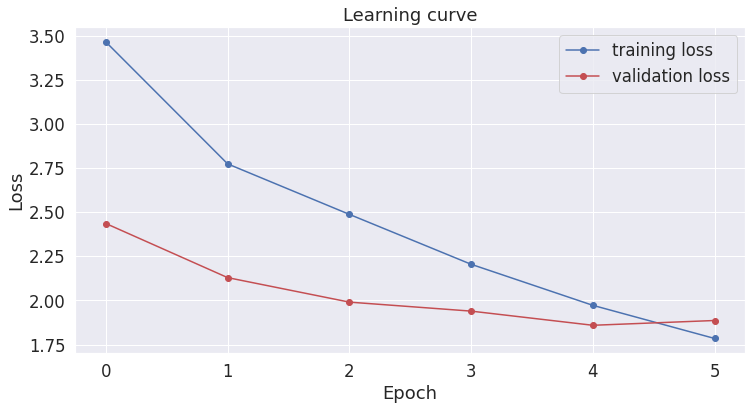

In [ ]:
history_dict = bert_history.history

precision = history_dict['precision']
val_precision = history_dict['val_precision']
recall = history_dict['recall']
val_recall = history_dict['val_recall']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(precision) + 1)

# Use plot styling from seaborn.
sns.set_style('darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss, 'b-o', label="training loss")
plt.plot(val_loss, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

### Precision & Recall Graph

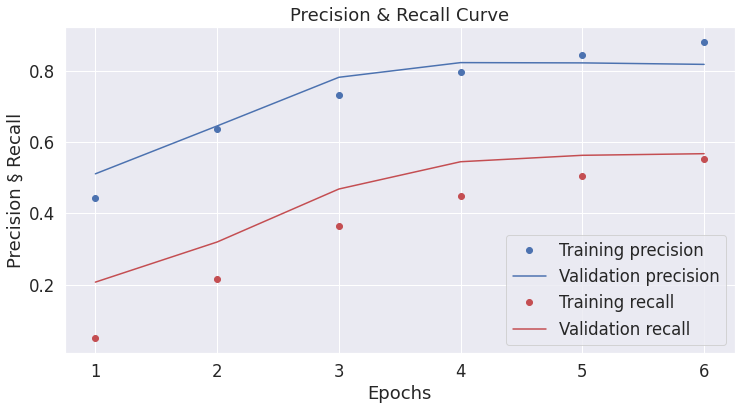

In [ ]:
plt.clf()   # clear figure

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(epochs, precision, 'bo', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.plot(epochs, recall, 'ro', label='Training recall')
plt.plot(epochs, val_recall, 'r', label='Validation recall')
plt.title('Precision & Recall Curve')
plt.xlabel('Epochs')
plt.ylabel('Precision § Recall')
plt.legend()

plt.show()

## Model Evaluation

### F1 Score & Precision & Recall & Subset Accuracy & Hamming Loss

In [ ]:
# Precision, Recall, F1 Score
random.seed(123)
results = model.evaluate([input_ids_test, mask_ids_test, segments_ids_test], multi_label_test)
f1_score = 2 * (results[1] * results[2])/(results[1] + results[2])

print("Test Precision: {}".format(round(results[1], 3)))
print("Test Recall: {}".format(round(results[2], 3)))
print("Test F1-Score: {}".format(round(f1_score,3)))

# Predictions
pred_labels = model.predict([input_ids_test, mask_ids_test, segments_ids_test])

multi_preds = pred_labels >= 0.10
multi_preds = multi_preds.astype(int)

# Average Precision Score
avp = average_precision_score(multi_label_test, multi_preds)
print("Test Average Precision Score: {}".format(round(avp)))
# Subset accuracy
print('Subset accuracy: {0}'.format(round(accuracy_score(multi_label_test, multi_preds, normalize=True, sample_weight=None), 3)))
# Hamming loss (smaller is better)
print('Hamming loss: {0}'.format(round(hamming_loss(multi_label_test, multi_preds), 3)))

19/19 [==============================] - 4s 208ms/step - loss: 1.8339 - precision: 0.8336 - recall: 0.6003 - false_negatives: 297.0000 - false_positives: 89.0000
Test F1-Score: 0.698
Test Precision: 0.834
Test Recall: 0.6
Test Average Precision Score: 0.0
Subset accuracy: 0.538
Hamming loss: 0.072


## Label Based Evaluation

### Classification Report

In [ ]:
categories = sorted(train.OpinionCategory.unique())
pred_bools = (multi_preds == 1)
true_bools = (multi_label_test == 1)
clf_report = classification_report(true_bools, pred_bools, target_names=categories
                                   )
print(clf_report)

                          precision    recall  f1-score   support

        AMBIENCE#GENERAL       0.41      0.88      0.56        57
           DRINKS#PRICES       0.00      0.00      0.00         3
          DRINKS#QUALITY       0.00      0.00      0.00        21
    DRINKS#STYLE_OPTIONS       0.00      0.00      0.00        12
             FOOD#PRICES       0.00      0.00      0.00        22
            FOOD#QUALITY       0.76      0.97      0.86       226
      FOOD#STYLE_OPTIONS       0.38      0.10      0.16        48
        LOCATION#GENERAL       0.00      0.00      0.00        13
      RESTAURANT#GENERAL       0.62      0.89      0.73       142
RESTAURANT#MISCELLANEOUS       0.34      0.36      0.35        33
       RESTAURANT#PRICES       0.29      0.10      0.14        21
         SERVICE#GENERAL       0.70      0.92      0.80       145

               micro avg       0.64      0.74      0.68       743
               macro avg       0.29      0.35      0.30       743
        

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion Matrices

Confusion matrix for label 0:
[[457  73]
 [  7  50]]
Recall: 0.98
Precision: 0.86
F1 Score: 0.92
ROC/AUC Score: 0.9
Sensitivity: 0.88
Specificity: 0.86

Confusion matrix for label 1:
[[584   0]
 [  3   0]]
Recall: 0.99
Precision: 1.0
F1 Score: 1.0
ROC/AUC Score: 0.9
Sensitivity: 0.0
Specificity: 1.0

Confusion matrix for label 2:
[[566   0]
 [ 21   0]]
Recall: 0.96
Precision: 1.0
F1 Score: 0.98
ROC/AUC Score: 0.9
Sensitivity: 0.0
Specificity: 1.0

Confusion matrix for label 3:
[[574   1]
 [ 12   0]]
Recall: 0.98
Precision: 1.0
F1 Score: 0.99
ROC/AUC Score: 0.9
Sensitivity: 0.0
Specificity: 1.0

Confusion matrix for label 4:
[[564   1]
 [ 22   0]]
Recall: 0.96
Precision: 1.0
F1 Score: 0.98
ROC/AUC Score: 0.9
Sensitivity: 0.0
Specificity: 1.0

Confusion matrix for label 5:
[[293  68]
 [  6 220]]
Recall: 0.98
Precision: 0.81
F1 Score: 0.89
ROC/AUC Score: 0.9
Sensitivity: 0.97
Specificity: 0.81

Confusion matrix for label 6:
[[531   8]
 [ 43   5]]
Recall: 0.93
Precision: 0.99
F1 Score: 0.9

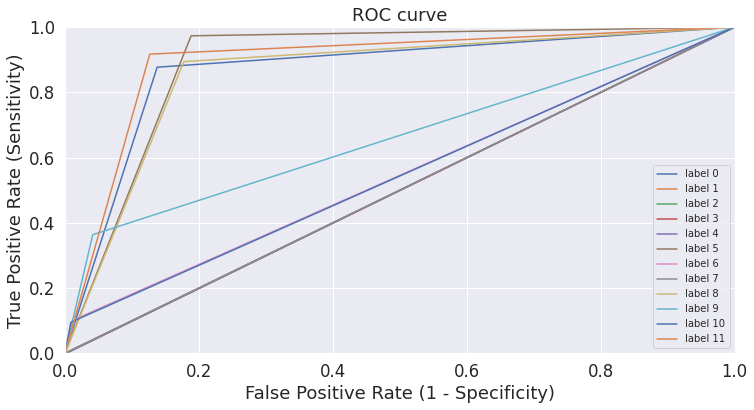

In [ ]:
# Confusion Matrices
# Setting the threshold as 0.10
df_pred = pd.DataFrame(pred_labels)
df_pred_clean = df_pred.apply(lambda x: [0 if y <= 0.10 else 1 for y in x])
pred_clean = np.array(df_pred_clean)

y_true = multi_label_test
y_pred = pred_clean

labels = range(12)

# Confusion Matrices
conf_mat_dict={}

for label_col in labels:
    y_true_label = y_true[:, label_col]
    y_pred_label = y_pred[:, label_col]
    conf_mat_dict.setdefault(label_col,[]).append(confusion_matrix(y_pred=y_pred_label, y_true=y_true_label))
    conf_mat_dict.setdefault(label_col,[]).append(y_true_label)
    conf_mat_dict.setdefault(label_col,[]).append(y_pred_label)

for label, values in conf_mat_dict.items():
    print("Confusion matrix for label {}:".format(label))
    matrix = values[0]
    print(matrix)
    recall = matrix[0][0] / (matrix[0][0] + matrix[1][0])
    print("Recall: {}".format(round(recall, 2)))
    precision = matrix[0][0] / (matrix[0][0] + matrix[0][1])
    print("Precision: {}".format(round(precision, 2)))
    f1_score =  2 * (precision * recall)/(precision + recall)
    print("F1 Score: {}".format(round(f1_score, 2)))
    true_label = values[1]
    pred_label = values[2]
    
    print("ROC/AUC Score: {}".format(round(roc_auc_score(y_true_label, y_pred_label),2)))
    fp, tp, thresholds = roc_curve(true_label, pred_label)
    def evaluate_threshold(tpr, fpr,clf_threshold, threshold):
      print('Sensitivity:', round(tp[thresholds > threshold][-1],2))
      print('Specificity:', 1 - round(fp[thresholds > threshold][-1],2))
    evaluate_threshold(tp, fp, thresholds, 0.1)
    print()
    plt.plot(fp, tp, label="label {}". format(label))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True)  

The label names corresponding to the indexes:
- 0: Ambience#General
- 1: Drinks#Prices
- 2: Drinks#Quality
- 3: Drinks#Style_Options
- 4: Food#Prices
- 5: Food#Quality
- 6: Food#Style_Options
- 7: Location#General
- 8: Restaurant#General
- 9: Restaurant#Miscelleanous
- 10: Restaurant#Prices
- 11: Service#General

## Output Frame

In [ ]:
label_cols = list(pd.DataFrame(multi_label).columns)
label_cols_test = list(pd.DataFrame(multi_label_test).columns)
label_names = sorted(train.OpinionCategory.values.unique())

idx2label = dict(zip(range(12),label_cols))
label2name = dict(zip(range(12),label_names))
print(idx2label), print(label2name)

# Getting indices of where boolean one hot vector true_bools is True so we can use idx2label to gather label names
true_label_idxs, pred_label_idxs =[],[]
for vals in true_bools:
  true_label_idxs.append(np.where(vals)[0].flatten().tolist())
for vals in pred_bools:
  pred_label_idxs.append(np.where(vals)[0].flatten().tolist())

# Gathering vectors of label names using idx2label
true_label_texts, pred_label_texts = [], []
for vals in true_label_idxs:
  if vals:
    true_label_texts.append([idx2label[val] for val in vals])
  else:
    true_label_texts.append(vals)

for vals in pred_label_idxs:
  if vals:
    pred_label_texts.append([idx2label[val] for val in vals])
  else:
    pred_label_texts.append(vals)

pred_names = []
for i in range(len(pred_label_texts)):
  j_list = []
  for j in pred_label_texts[i]:
    j_list.append(label2name[j])
  pred_names.append(j_list)

    # Decoding input ids to comment text
#comment_texts = [tokenizer.decode(text,skip_special_tokens=True,clean_up_tokenization_spaces=False) for text in tokenized_texts]

# Converting lists to df
comparisons_df = pd.DataFrame({'comment_text': test_Text, 'true_labels': true_label_texts, 'pred_labels':pred_label_texts, 'pred_names':pred_names})
comparisons_df.to_csv('comparisons_tensorflow.csv')
comparisons_df.to_excel('comparisons_df.xlsx')
comparisons_df.head()

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11}
{0: 'AMBIENCE#GENERAL', 1: 'DRINKS#PRICES', 2: 'DRINKS#QUALITY', 3: 'DRINKS#STYLE_OPTIONS', 4: 'FOOD#PRICES', 5: 'FOOD#QUALITY', 6: 'FOOD#STYLE_OPTIONS', 7: 'LOCATION#GENERAL', 8: 'RESTAURANT#GENERAL', 9: 'RESTAURANT#MISCELLANEOUS', 10: 'RESTAURANT#PRICES', 11: 'SERVICE#GENERAL'}


,comment_text,true_labels,pred_labels,pred_names
0,Yum!,[5],[5],[FOOD#QUALITY]
1,Serves really good sushi.,[5],[5],[FOOD#QUALITY]
2,Not the biggest portions but adequate.,[6],[5],[FOOD#QUALITY]
3,Green Tea creme brulee is a must!,[5],[5],[FOOD#QUALITY]
4,Don't leave the restaurant without it.,[5],[8],[RESTAURANT#GENERAL]
